In [1]:
!python3 --version

Python 3.10.14


In [2]:
!pip install pyqubo openjij


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [3]:
!which pip

/Users/aaaaa/.pyenv/versions/3.10.14/bin/pip


In [1]:
from pyqubo import Array, Placeholder, solve_ising, Constraint, SubH, Model, Binary
import re, random, math
import numpy as np
import openjij as oj
import time 

データ保存・参照したい場合はデータ名に気をつけて

ver2と比較したい場合はタスク長の大きさは合わせる必要があるかな

In [5]:
# resourceに番号を割り当てる
def assign_resource_num(resource):
    resource_num = {}
    cnt = 0
    for i in resource:
        for j in resource[i]:
            resource_num[j] = cnt
            cnt += 1
    return resource_num

In [6]:
# スケジューリング問題のjobリソースを生成
def generate_jobs_and_resources(num_jobs, seed=None):
    resource_t = {'R0': [], 'R1': [], 'R2': []}
    place = []
    job = []
    job_tasks = {}  # タスク長を格納する辞書

    # シードを設定（指定された場合のみ）
    if seed is not None:
        random.seed(seed)

    for i in range(1, num_jobs + 1):
        t11 = f't{i}1'
        t12 = f't{i}2'
        t13 = f't{i}3'

        job.append([t11, t12, t13])

        resource_t['R0'].append(t11)
        resource_t['R1'].append(t12)
        resource_t['R2'].append(t13)

        place.append([f'p{i}1', f'p{i}2', f'p{i}3', f'p{i}4'])

        # 各タスクに1から10の範囲でランダムなタスク長を割り当てる
        job_tasks[t11] = random.randint(1, 8)  # t11にランダムなタスク長を割り当て
        job_tasks[t12] = random.randint(1, 8)  # t12にランダムなタスク長を割り当て
        job_tasks[t13] = random.randint(1, 8)  # t13にランダムなタスク長を割り当て

    return resource_t, place, job, job_tasks

In [7]:
resource_m = {'R0': ['m11', 'm12'], 'R1': ['m21', 'm22'], 'R2': ['m31', 'm32']}
machine_processing_time = {'m11': 1, 'm12': 2, 'm21': 3, 'm22': 1, 'm31': 1, 'm32': 3}
# machine_processing_time = {'m11': 2, 'm12': 4, 'm21': 6, 'm22': 2, 'm31': 2, 'm32': 6}
machine_cost = {'m11': 10, 'm12': 14, 'm21': 13, 'm22': 10, 'm31': 12, 'm32': 10}
# machine_cost = {'m11': 5, 'm12': 7, 'm21': 6, 'm22': 5, 'm31': 6, 'm32': 5}

resource_num = assign_resource_num(resource_m)

resource_num

{'m11': 0, 'm12': 1, 'm21': 2, 'm22': 3, 'm31': 4, 'm32': 5}

In [8]:
# ジョブ数を指定して生成
num_jobs = 7
resource_t, place, job, job_tasks = generate_jobs_and_resources(num_jobs, seed=42)

In [9]:
job_tasks = {'t11': 2,
 't12': 1,
 't13': 5,
 't21': 4,
 't22': 4,
 't23': 3,
 't31': 2,
 't32': 2,
 't33': 7,
 't41': 1,
 't42': 1,
 't43': 2,
 't51': 4,
 't52': 4,
 't53': 1,
 't61': 4,
 't62': 7,
 't63': 4,
 't71': 8,
 't72': 5,
 't73': 1}

In [10]:
job_tasks

{'t11': 2,
 't12': 1,
 't13': 5,
 't21': 4,
 't22': 4,
 't23': 3,
 't31': 2,
 't32': 2,
 't33': 7,
 't41': 1,
 't42': 1,
 't43': 2,
 't51': 4,
 't52': 4,
 't53': 1,
 't61': 4,
 't62': 7,
 't63': 4,
 't71': 8,
 't72': 5,
 't73': 1}

In [11]:
# トランジションに番号を割り当てる
transition_num = {}
cnt = 0
for i in job:
    for j in i:
        transition_num[j] = cnt
        cnt += 1
transition_num

{'t11': 0,
 't12': 1,
 't13': 2,
 't21': 3,
 't22': 4,
 't23': 5,
 't31': 6,
 't32': 7,
 't33': 8,
 't41': 9,
 't42': 10,
 't43': 11,
 't51': 12,
 't52': 13,
 't53': 14,
 't61': 15,
 't62': 16,
 't63': 17,
 't71': 18,
 't72': 19,
 't73': 20}

In [12]:
t_num = len(transition_num)
r_num = len(resource_num)
limit_time = 30 #制限の最大時間
x = Array.create('x', (limit_time,t_num,r_num), 'BINARY') # binaryの宣言

## Binary変数
x(時間,トランジション,マシーン)

In [13]:
def cal_min_processing(resource_m, machine_processing_time):
    """
    各リソースマシーンのprocessing timeの最小を求める
    Args:
        resource_m : リソースマシーンの辞書型
        machine_processing_time : マシーンの処理時間の辞書型

    Returns:
        R0,R1,R2それぞれのprocessing timeの最小時間を求める
    """
    min_m_time = []
    for idx,v in enumerate(resource_m):
        _min = 10000
        for i in resource_m[v]:
            _min = min(_min,machine_processing_time[i])
        min_m_time.append(_min)
    return min_m_time

In [14]:
def cal_max_processing(resource_m, machine_processing_time):
    """
    各リソースマシーンのprocessing timeの最大を求める
    Args:
        resource_m : リソースマシーンの辞書型
        machine_processing_time : マシーンの処理時間の辞書型

    Returns:
        R0,R1,R2それぞれのprocessing timeの最大時間を求める
    """
    max_m_time = []
    for idx,v in enumerate(resource_m):
        _min = -1
        for i in resource_m[v]:
            _min = max(_min,machine_processing_time[i])
        max_m_time.append(_min)
    return max_m_time

In [15]:
def calc_upper_limit(step, jobs, limit_time, _max):
    """
    現在のステップにおける処理時間の上限時間の計算
    Args:
        step : 現在のステップ
        jobs : 各jobのタスクのリスト
        limit_time : 制限時間
        _max : 各リソースマシーンのprocessing timeの最大値のリスト(max_list)

    Returns:
    現在のステップの上限時間を求める
    """
    p_time = 0
    for job in jobs: #jobはstr型
        if len(job) >= 4:
            if int(job[3]) >= step:
                p_time += _max[int(job[3])-1]
        elif int(job[2]) >= step:
                p_time += _max[int(job[2])-1]
    return limit_time - p_time

In [16]:
# 各トランジションの処理時間の最大・最小値を求める
range_trantision_ptime = {}
min_list = cal_min_processing(resource_m, machine_processing_time)
max_list = cal_max_processing(resource_m, machine_processing_time)

#各タスクの下限と上限時間
#'t11': [0, 22] t11は最低0秒、最高22秒で開始しなければならない
for idx, j in enumerate(job):
    for i in range(len(j)):
        range_time = []
        lb = sum(min_list[0:i]) if i != 0 else 0
        range_time.append(lb)
        ub = calc_upper_limit(i+1, j, limit_time, max_list)
        range_time.append(ub)
        range_trantision_ptime[j[i]] = range_time
range_trantision_ptime

{'t11': [0, 14],
 't12': [2, 18],
 't13': [4, 24],
 't21': [0, 14],
 't22': [2, 18],
 't23': [4, 24],
 't31': [0, 14],
 't32': [2, 18],
 't33': [4, 24],
 't41': [0, 14],
 't42': [2, 18],
 't43': [4, 24],
 't51': [0, 14],
 't52': [2, 18],
 't53': [4, 24],
 't61': [0, 14],
 't62': [2, 18],
 't63': [4, 24],
 't71': [0, 14],
 't72': [2, 18],
 't73': [4, 24]}

## H_firing

In [17]:
#制約
H_firing = 0.0
for idx, j in enumerate(job):
    for i in range(len(j)):
        sigma_h_firing = 0.0
        for r in resource_m['R'+str(i)]:
            lb = range_trantision_ptime[j[i]][0]
            ub = range_trantision_ptime[j[i]][1]
            for k in range(lb,ub):
                t = transition_num['t'+str(idx+1)+str(i+1)]
                sigma_h_firing += x[k,t,resource_num[r]]
        H_firing += Constraint((1-sigma_h_firing)**2,label="one_fired_t{}{}{}".format(idx+1,i+1,resource_num[r]))

## H_conflict

In [18]:
#制約
H_conflict = 0.0

for i in range(len(resource_m)):
    for r in resource_m['R'+str(i)]:
        for j1 in range(len(job)):
            t1 = transition_num[job[j1][i]]
            for j2 in range(len(job)):
                t2 = transition_num[job[j2][i]]
                if j1 != j2:
                    lb = range_trantision_ptime[job[j1][i]][0]
                    ub = range_trantision_ptime[job[j1][i]][1]
                    
                    # j1 のタスク処理時間を計算
                    task_length = job_tasks[job[j1][i]]
                    processing_time = math.ceil(task_length / machine_processing_time[r])
                    
                    for k1 in range(lb,limit_time+1):
                        fd = k1 + processing_time

                        for k2 in range(k1,min(fd,limit_time)):
                            H_conflict += Constraint((x[k1,t1,resource_num[r]])*(x[k2,t2,resource_num[r]]), label="conflict{}".format(t1))


## H_precedence

In [19]:
#制約
H_precedence = 0.0

for idx, j in enumerate(job):
    for i in range(len(j)):
        lb = range_trantision_ptime[j[i]][0]
        ub = range_trantision_ptime[j[i]][1]
        for r1 in resource_m['R'+str(i)]:
            if i+1 < len(j):
                for r2 in resource_m['R'+str((i+1))]:
                    t1 = transition_num['t'+str(idx+1)+str(i+1)]
                    t2 = transition_num['t'+str(idx+1)+str(i+2)]
                    
                    task_length = job_tasks['t'+str(idx+1)+str(i+1)] # 現在のタスクの長さ
                    processing_time = math.ceil(task_length / machine_processing_time[r1])
                            
                    for k1 in range(0, limit_time):
                        fd = k1 + processing_time

                        for k2 in range(min(fd, limit_time)):
                            H_precedence += Constraint((x[k1,t1,resource_num[r1]])*(x[k2,t2,resource_num[r2]]), 
                                                       label="precedence{}{}{}{}".format(k1,t1,k2,t2))


## H_resourceCost

In [20]:
#目的関数
H_resourceCost = 0.0

for j in range(len(job)):  # j = 0,1,2,3,4
    for i in range(len(job[j])):  # i = 0,1,2 (タスク数)
        task_key = 't' + str(j + 1) + str(i + 1)

        if task_key in job_tasks:
            task_length = job_tasks[task_key]  # タスク長
            lb = range_trantision_ptime[task_key][0]
            ub = range_trantision_ptime[task_key][1]
            t = transition_num[task_key]

            # **適切なリソースグループを選択する**
            if 'R' + str(i) in resource_m:
                for r in resource_m['R' + str(i)]:  # i 番目のタスクのリソースのみ選択
                    r_num = resource_num[r]
                    rc = machine_cost[r]  # リソースのコスト

                    # **適切なマシンリソースを取得**
                    machine_resource = machine_processing_time[r]
                    processing_time = math.ceil(task_length / machine_resource)

                    for k in range(lb, ub):
                        H_resourceCost += rc * processing_time * x[k, t, r_num]


## H_waitingTime

In [21]:
H_waitingTime = 0.0

for j in range(len(job)):
    for i in range(len(job[j])-1):
        # 後のタスク
        task_key1 = 't' + str(j + 1) + str(i + 2)
        if task_key1 in job_tasks:
            task_length1 = job_tasks[task_key1]
        else:
            continue  # タスクがなければスキップ

        lb1 = range_trantision_ptime[task_key1][0]
        ub1 = range_trantision_ptime[task_key1][1]
        t1 = transition_num[task_key1]

        # 前のタスク
        task_key2 = 't' + str(j + 1) + str(i + 1)
        if task_key2 in job_tasks:
            task_length2 = job_tasks[task_key2]
        else:
            continue  # タスクがなければスキップ

        lb2 = range_trantision_ptime[task_key2][0]
        ub2 = range_trantision_ptime[task_key2][1]
        t2 = transition_num[task_key2]

        for k1 in range(lb1, ub1):
            for r1 in resource_m['R' + str(i + 1)]:
                r_num1 = resource_num[r1]

                for k2 in range(lb2, ub2):
                    for r2 in resource_m['R' + str(i)]:
                        r_num2 = resource_num[r2]

                        # タスクの処理時間の計算
                        machine_resource = machine_processing_time.get(r2, 1)  # 0除算防止
                        processing_time = math.ceil(task_length2 / machine_resource)

                        # 待ち時間の計算
                        fd = k2 + processing_time
                        if k1 - fd >= 0:
                            H_waitingTime += (k1 - fd) * x[k2, t2, r_num2] * x[k1, t1, r_num1]


## ベイズ最適化

In [22]:
import pandas as pd
import optuna
import openjij as oj
import re


# 結果を保存するためのリスト
results = []
decoded_results = []  # sort_ans を保存するためのリスト

def extractVariable(s):  
    literal = re.split('[\[\]]', s)
    while '' in literal:
        literal.remove('')       
    return literal

# 初期値を設定
param_initial_values = {
    "A": 1008.83,
    "B": 180.95,
    "C": 331.45,
    "D": 4.94,
    "E": 1.04
}

def objective(trial):#難しければトライアンドエラー
    
    A = trial.suggest_float("A", 1000, 2000)
    B = trial.suggest_float("B", 180, 220)
    C = trial.suggest_float("C", 250, 350)
    D = trial.suggest_float("D", 1, 10)
    E = trial.suggest_float("E", 1, 10)
    
    H = (
        SubH(A * H_firing, "SubH1") +
        SubH(B * H_conflict, "SubH2") +
        SubH(C * H_precedence, "SubH3") +
        SubH(D * H_resourceCost, "SubH4") +
        SubH(E * H_waitingTime, "SubH5")
    )
    
    model = H.compile()
    # feed_dict = {"A": 699, "B": 192, "C": 241, "D": D, "E": E}
    feed_dict = {"A": A, "B": B, "C": C, "D": D, "E": E}
    bqm = model.to_bqm(feed_dict=feed_dict)
    
    # アニーリング回数
    num_iterations = 100

    # QUBOを辞書形式に変換
    qubo_dict = bqm.to_qubo()[0]

    sampler = oj.SASampler()
    response = sampler.sample_qubo(qubo_dict, num_reads=num_iterations)

    # サンプリング結果をデコード
    decoded_samples = model.decode_sampleset(response, feed_dict=feed_dict)

    # 最良のサンプルを選択
    best_sample = min(decoded_samples, key=lambda x: x.energy)

    # サンプルから値が1の変数を抽出
    keys = [k for k, v in best_sample.sample.items() if v == 1]
    
    ans = []

    for k in keys:
        ans.append(extractVariable(k))

    sort_ans = list(range(len(ans)))

    for i in ans:
        sort_ans[int(i[2])] = i

    # sort_ans をリストに保存
    decoded_results.append({
        "trial": trial.number,
        "energy": best_sample.energy,
        "sort_ans": sort_ans  # ソートされたデコード結果
    })

    # feasibleかどうかを確認
    feasible = all(best_sample.subh.get(i, float('inf')) == 0 for i in ['SubH1', 'SubH2', 'SubH3'])

    # 他の結果を保存
    results.append({
        "trial": trial.number,
        "num_qubits": len(bqm.variables),
        "energy": best_sample.energy,
        "feasible": feasible,
        "SubH1": best_sample.subh['SubH1'],
        "SubH2": best_sample.subh['SubH2'],
        "SubH3": best_sample.subh['SubH3'],
        "SubH4": best_sample.subh['SubH4'],
        "SubH5": best_sample.subh['SubH5'],
        "A": A,
        "B": B,
        "C": C,
        "D": D,
        "E": E
    })

    if not feasible:
        penalty_value = 1000  # ペナルティ値を具体的に設定
        return penalty_value, penalty_value


    # feasible であれば SubH4 と SubH5 の値を返す
    return best_sample.subh['SubH4'], best_sample.subh['SubH5']


/Users/aaaaa/.pyenv/versions/3.10.14/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


: 

In [ ]:
from optuna.samplers import TPESampler  # ここを追加

# Optuna の最適化を実行
sampler = TPESampler(multivariate=True, group=True, prior_weight=1.0, seed=1234)
study = optuna.create_study(directions=('minimize', 'minimize'), sampler=sampler)
study.enqueue_trial(param_initial_values) 
study.optimize(objective, n_trials=100)

# 結果をデータフレームに変換
df_results = pd.DataFrame(results)
df_decoded = pd.DataFrame(decoded_results)

# 結果をCSVファイルとして保存
df_results.to_csv("./search/job7/exam/optimization_results_job7_3.csv", index=False)
df_decoded.to_csv("./search/job7/exam/decoded_results_job7_3.csv", index=False)

/Users/aaaaa/.pyenv/versions/3.10.14/lib/python3.10/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
/Users/aaaaa/.pyenv/versions/3.10.14/lib/python3.10/site-packages/optuna/samplers/_tpe/sampler.py:330: ExperimentalWarning: ``group`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-02-04 12:52:50,736] A new study created in memory with name: no-name-14f9d295-436b-4fa6-a014-8b9b22b116cd
[I 2025-02-04 12:52:59,375] Trial 0 finished with values: [1000.0, 1000.0] and parameters: {'A': 1008.83, 'B': 180.95, 'C': 331.45, 'D': 4.94, 'E': 1.04}. 
[I 2025-02-04 12:53:08,192] Trial 1 finished with values: [1000.0, 1000.0] and parameters: {'A': 1191.5194503788923, 'B': 204.8843508415933, 'C': 293.77277390071146, 'D': 8.068227253423924, 'E': 8.019782273069232}. 
[I 2025-02-04 12:53:17,100] Trial 2 finished with value

## ガントチャートに表したい結果を引数指定してもってくる

In [20]:
import pandas as pd
result1 = pd.read_csv("./search/job6/exam/optimization_results_job6_10.csv")
result2 = pd.read_csv("./search/job6/exam/decoded_results_job6_10.csv")

In [21]:
# result1 をデータフレームに変換
df = pd.DataFrame(result1)

# feasible が True の行だけ抽出
feasible_df = df[df["feasible"] == True]

# 抽出結果を表示
print(feasible_df)


    trial  num_qubits       energy  feasible  SubH1  SubH2  SubH3  \
41     41        1080  2715.383991      True    0.0    0.0    0.0   

          SubH4      SubH5            A           B          C         D  \
41  2677.193589  38.190402  1073.301264  186.633304  324.19879  6.935735   

           E  
41  1.157285  


In [22]:
print(feasible_df['SubH4'] / feasible_df['D'])

41    386.0
dtype: float64


In [23]:
print(feasible_df['SubH5'] / feasible_df['E'])

41    33.0
dtype: float64


In [7]:
sort_ans = result2["sort_ans"][57]

In [29]:
sort_ans

"[['x', '7', '0', '0'], ['x', '11', '1', '3'], ['x', '16', '2', '5'], ['x', '0', '3', '1'], ['x', '7', '4', '2'], ['x', '26', '5', '5'], ['x', '4', '6', '0'], ['x', '5', '7', '2'], ['x', '14', '8', '5'], ['x', '29', '9', '1'], 10, ['x', '3', '11', '5'], ['x', '7', '12', '1'], ['x', '14', '13', '3'], ['x', '27', '14', '4'], ['x', '29', '15', '0'], 16, ['x', '3', '17', '4'], ['x', '9', '18', '1'], ['x', '19', '19', '2'], ['x', '24', '20', '4'], 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]"

In [30]:
import ast
sort_ans = ast.literal_eval(sort_ans)
sort_ans

[['x', '7', '0', '0'],
 ['x', '11', '1', '3'],
 ['x', '16', '2', '5'],
 ['x', '0', '3', '1'],
 ['x', '7', '4', '2'],
 ['x', '26', '5', '5'],
 ['x', '4', '6', '0'],
 ['x', '5', '7', '2'],
 ['x', '14', '8', '5'],
 ['x', '29', '9', '1'],
 10,
 ['x', '3', '11', '5'],
 ['x', '7', '12', '1'],
 ['x', '14', '13', '3'],
 ['x', '27', '14', '4'],
 ['x', '29', '15', '0'],
 16,
 ['x', '3', '17', '4'],
 ['x', '9', '18', '1'],
 ['x', '19', '19', '2'],
 ['x', '24', '20', '4'],
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64]

In [31]:
feasible_df.shape

(0, 14)

In [32]:
resource_num = assign_resource_num(resource_m)
resource_num

{'m11': 0, 'm12': 1, 'm21': 2, 'm22': 3, 'm31': 4, 'm32': 5}

In [33]:
# transition_num と resource_num のキーと値を反転させる
transition_name = {v: k for k, v in transition_num.items()}
resource_name = {v: k for k, v in resource_num.items()}

# 結果を格納する辞書
task_to_resource = {}

# sort_ans を解析して、タスクとリソースの対応関係を取得
for entry in sort_ans:
    if isinstance(entry, list) and len(entry) == 4:
        _, _, task_num_str, resource_num_str = entry
        task_num = int(task_num_str)
        resource_num = int(resource_num_str)
        task_name = transition_name.get(task_num)
        resource_name_str = resource_name.get(resource_num)
        if task_name and resource_name_str:
            task_to_resource[task_name] = resource_name_str

# 結果を表示
print(task_to_resource)



{'t11': 'm11', 't12': 'm22', 't13': 'm32', 't21': 'm12', 't22': 'm21', 't23': 'm32', 't31': 'm11', 't32': 'm21', 't33': 'm32', 't41': 'm12', 't43': 'm32', 't51': 'm12', 't52': 'm22', 't53': 'm31', 't61': 'm11', 't63': 'm31', 't71': 'm12', 't72': 'm21', 't73': 'm31'}


## 結果をガントチャートで

Task t11: Processing time = 1
Task t12: Processing time = 1
Task t13: Processing time = 1
Task t21: Processing time = 1
Task t22: Processing time = 1
Task t23: Processing time = 1
Task t31: Processing time = 1
Task t32: Processing time = 1
Task t33: Processing time = 2
Task t41: Processing time = 1
Task t43: Processing time = 1
Task t51: Processing time = 1
Task t52: Processing time = 2
Task t53: Processing time = 1
Task t61: Processing time = 2
Task t63: Processing time = 2
Task t71: Processing time = 2
Task t72: Processing time = 1
Task t73: Processing time = 1


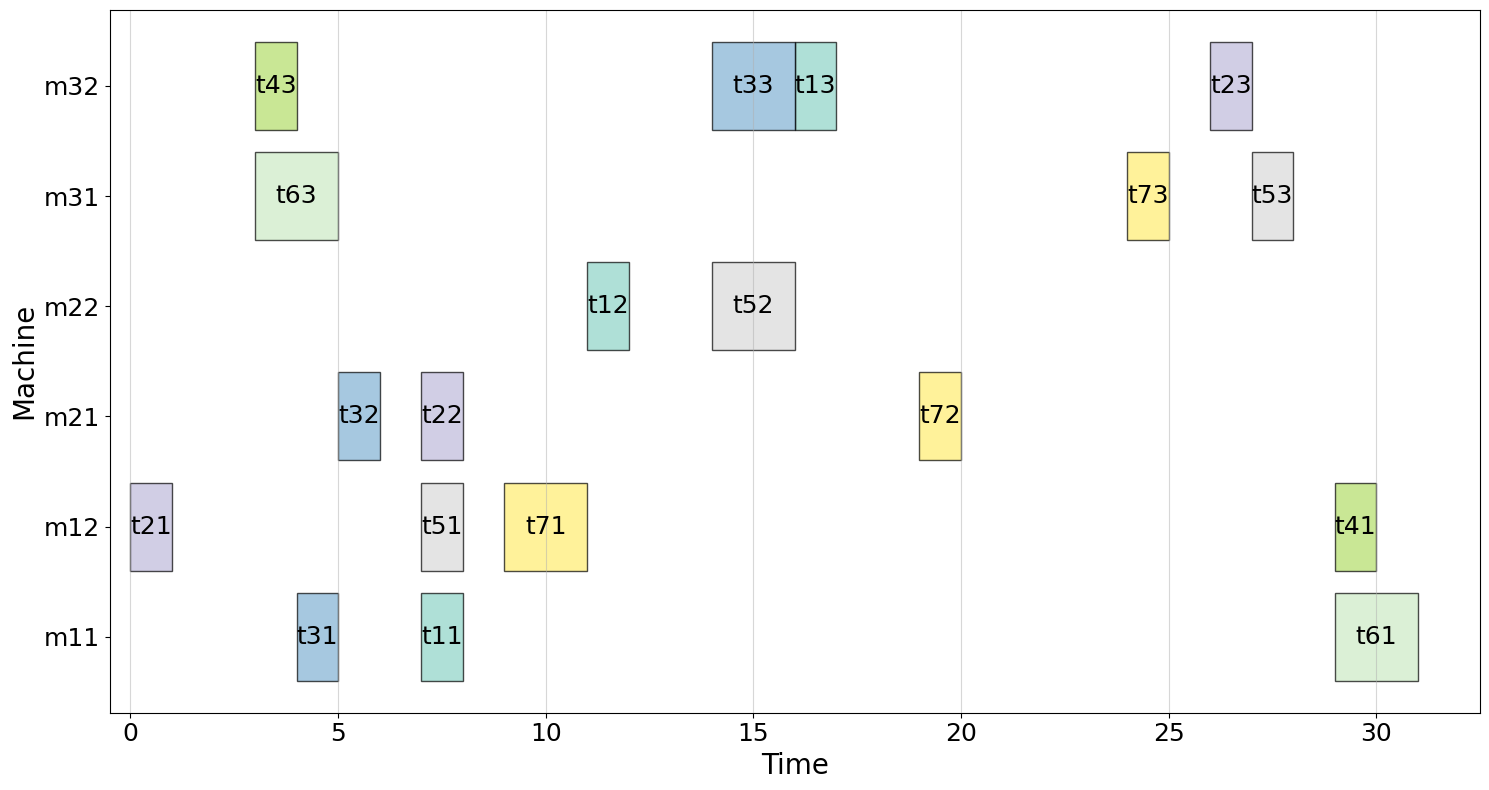

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import math

def create_gantt_chart(transition_num, task_to_resource, sort_ans, job_tasks, machine_processing_time, job):
    # 全てのマシンリソースを取得
    all_machines = sorted(list(machine_processing_time.keys()))
    machine_to_idx = {machine: idx for idx, machine in enumerate(all_machines)}
    
    # タスクの開始時間とマシン割り当てを整理
    task_details = defaultdict(dict)
    
    # sort_ansからタスクの情報を取得
    for schedule in sort_ans:
        if isinstance(schedule, list):  # リストの場合のみ処理
            task_id = int(schedule[2])  # タスク番号
            start_time = int(schedule[1])  # 開始時刻
            
            # task_idに対応するタスク名を見つける
            task_name = None
            for task, tid in transition_num.items():
                if tid == task_id:
                    task_name = task
                    break
                    
            if task_name:
                task_details[task_name]['machine'] = task_to_resource[task_name]
                task_details[task_name]['start'] = start_time
                task_details[task_name]['id'] = task_id
    
    # プロットの設定
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # ジョブごとに異なる色を設定
    colors = plt.cm.Set3(np.linspace(0, 1, len(job)))  # ジョブ数に応じたカラーマップ
    job_colors = {tuple(tasks): color for tasks, color in zip(job, colors)}  # ジョブと色を対応付け
    
    # タスクをプロット
    for task, details in task_details.items():
        machine = details['machine']
        start_time = details['start']
        
        # タスクの処理時間を計算
        duration = math.ceil(job_tasks[task] / machine_processing_time[machine])
        
        # タスク名が属するジョブを見つけて色を設定
        task_color = None
        for tasks in job:
            if task in tasks:
                task_color = job_colors[tuple(tasks)]
                break
        
        if task_color is None:
            raise ValueError(f"Task {task} not found in job list")
        
        # タスクの処理時間を表示
        print(f"Task {task}: Processing time = {duration}")
        
        ax.barh(y=machine_to_idx[machine],
                width=duration,
                left=start_time,
                color=task_color,
                alpha=0.7,
                edgecolor='black')
        
        # タスク名をバーの中央に表示（フォントサイズ変更）
        ax.text(start_time + duration / 2,
                machine_to_idx[machine],
                task,
                ha='center',
                va='center',
                fontsize=18)  # ← タスク名のフォントサイズを大きく
    
    # グラフの装飾（フォントサイズ変更）
    ax.set_yticks(range(len(all_machines)))
    ax.set_yticklabels(all_machines, fontsize=18)  # y軸のフォントサイズを大きく
    ax.set_xlabel('Time', fontsize=20)  # x軸ラベルのフォントサイズを大きく
    ax.set_ylabel('Machine', fontsize=20)  # y軸ラベルのフォントサイズを大きく
    
    # x軸の目盛フォントサイズを変更
    plt.xticks(fontsize=18)

    # グリッド線の追加
    ax.grid(True, axis='x', alpha=0.5)  # グリッド線の透明度を調整
    
    # x軸の範囲を調整
    max_time = max(
        details['start'] + job_tasks[task] / machine_processing_time[details['machine']]
        for task, details in task_details.items()
    )
    ax.set_xlim(-0.5, max_time + 1.5)
    
    plt.tight_layout()
    return fig, ax

# タスクスケジュールの例
fig, ax = create_gantt_chart(transition_num, task_to_resource, sort_ans, job_tasks, machine_processing_time, job)
plt.show()


Task t11: Processing time = 1
Task t12: Processing time = 1
Task t13: Processing time = 1
Task t21: Processing time = 1
Task t22: Processing time = 1
Task t23: Processing time = 1
Task t31: Processing time = 1
Task t32: Processing time = 1
Task t33: Processing time = 2
Task t41: Processing time = 1
Task t43: Processing time = 1
Task t51: Processing time = 1
Task t52: Processing time = 2
Task t53: Processing time = 1
Task t61: Processing time = 2
Task t63: Processing time = 2
Task t71: Processing time = 2
Task t72: Processing time = 1
Task t73: Processing time = 1


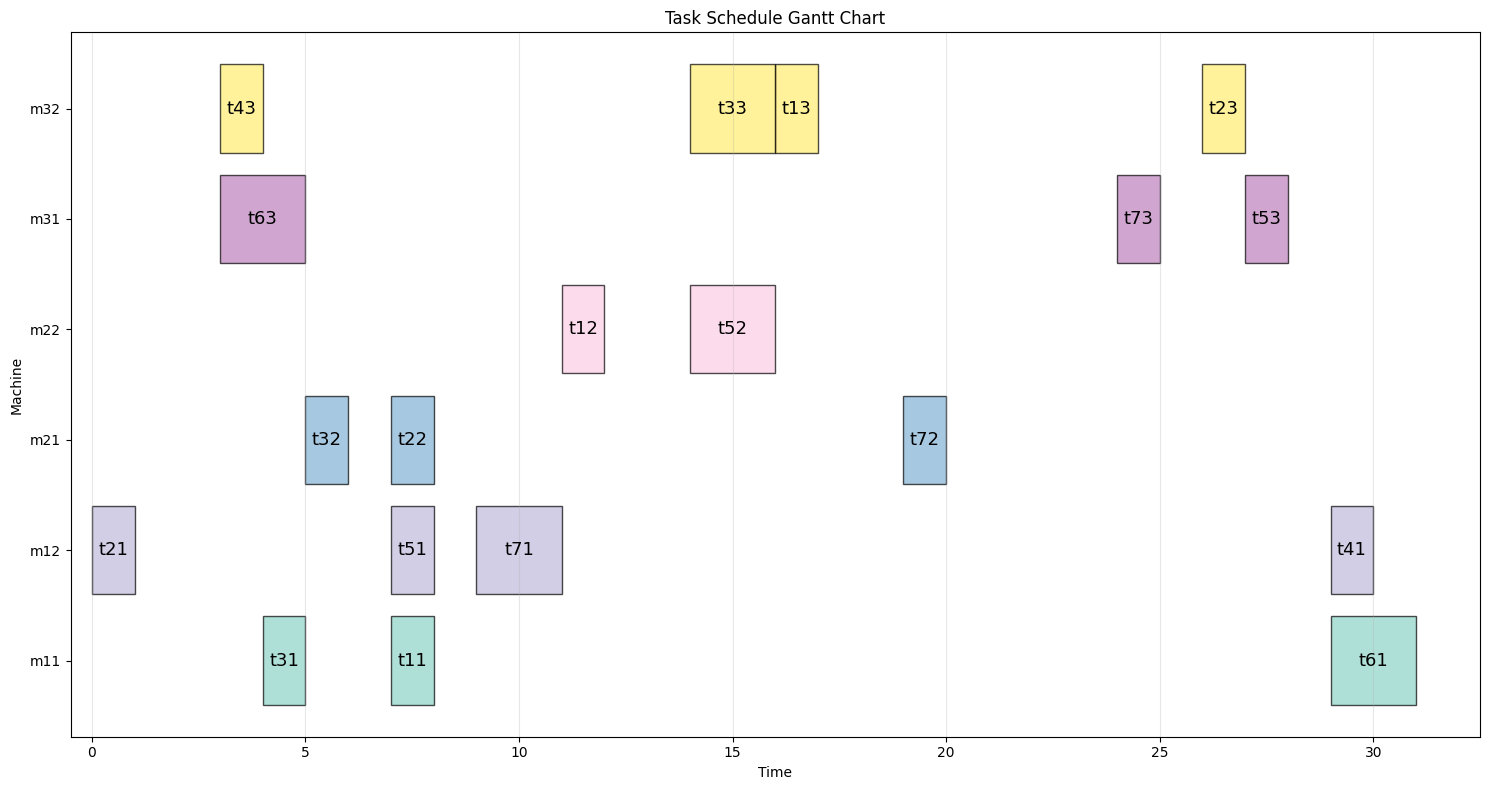

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import math

def create_gantt_chart(transition_num, task_to_resource, sort_ans, job_tasks, machine_processing_time):
    # 全てのマシンリソースを取得
    all_machines = sorted(list(machine_processing_time.keys()))
    machine_to_idx = {machine: idx for idx, machine in enumerate(all_machines)}
    
    # タスクの開始時間とマシン割り当てを整理
    task_details = defaultdict(dict)
    
    # sort_ansからタスクの情報を取得
    for schedule in sort_ans:
        if isinstance(schedule, list):  # リストの場合のみ処理
            task_id = int(schedule[2])  # タスク番号
            start_time = int(schedule[1])  # 開始時刻
            
            # task_idに対応するタスク名を見つける
            task_name = None
            for task, tid in transition_num.items():
                if tid == task_id:
                    task_name = task
                    break
                    
            if task_name:
                task_details[task_name]['machine'] = task_to_resource[task_name]
                task_details[task_name]['start'] = start_time
                task_details[task_name]['id'] = task_id
    
    # プロットの設定
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # 色の設定
    colors = plt.cm.Set3(np.linspace(0, 1, len(all_machines)))
    machine_colors = dict(zip(all_machines, colors))
    
    # タスクをプロット
    for task, details in task_details.items():
        machine = details['machine']
        start_time = details['start']
        
        # タスクの処理時間を計算
        duration = math.ceil(job_tasks[task] / machine_processing_time[machine])
        
        # タスクの処理時間を表示
        print(f"Task {task}: Processing time = {duration}")
        
        ax.barh(y=machine_to_idx[machine],
                width=duration,
                left=start_time,
                color=machine_colors[machine],
                alpha=0.7,
                edgecolor='black')
        
        # タスク名をバーの中央に表示
        ax.text(start_time + duration / 2,
                machine_to_idx[machine],
                task,
                ha='center',
                va='center',
                fontsize=13)
    
    # グラフの装飾
    ax.set_yticks(range(len(all_machines)))
    ax.set_yticklabels(all_machines)
    ax.set_xlabel('Time')
    ax.set_ylabel('Machine')
    ax.set_title('Task Schedule Gantt Chart')
    
    # グリッド線の追加
    ax.grid(True, axis='x', alpha=0.3)
    
    # x軸の範囲を調整
    max_time = max(
        details['start'] + job_tasks[task] / machine_processing_time[details['machine']]
        for task, details in task_details.items()
    )
    ax.set_xlim(-0.5, max_time + 1.5)
    
    plt.tight_layout()
    return fig, ax

# タスクスケジュールの例
fig, ax = create_gantt_chart(transition_num, task_to_resource, sort_ans, job_tasks, machine_processing_time)
plt.show()

## データをcsvに保存する

In [36]:
# import csv
# import os
# from datetime import datetime

# now = datetime.now()
# timestamp = now.strftime('%Y-%m-%d')

# # 保存するファイル名
# csv_filename = f'./search/t_30/0901/{timestamp}_patt30_job{num_jobs}.csv' #任意のファイル名

# # CSVファイルが存在するかどうかを確認
# file_exists = os.path.isfile(csv_filename)

# constraint_error = best_sample.constraints(only_broken=True)
# feasible = 0 if is_feasible else constraint_error 
# #制約違反起こしてない場合もある、そのときはサブハミルトニアンが0ではない場合があるので出力する様にしている

# # データをリストのリストとして準備
# # data = [[num_iterations, machine_cost, processing_time, resource_cost, wating_time, feasible]]
# data = [[num_iterations, resource_cost, waiting_time, feasible]]

# # ファイルが存在しない場合はヘッダーを追加
# if not file_exists:
#     with open(csv_filename, mode='w', newline='') as file:
#         writer = csv.writer(file)
#         # writer.writerow(['iteration', 'machine_cost', 'processing_time', 'resource_cost', 'wating_time','feasible'])
#         writer.writerow(['iteration', 'resource_cost', 'waiting_time','feasible'])
#         writer.writerows(data)
# else:
#     # ファイルが存在する場合は追記
#     with open(csv_filename, mode='a', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerows(data)

## データに対して平均と分散をplot

In [37]:
# import pandas as pd
# import numpy as np
# import re
# import glob
# import matplotlib.pyplot as plt

# # 全パターンのファイルパスを取得
# file_paths = glob.glob("../search/t_30/0901/2024-09-01_patt*_job15.csv") #任意のファイル名
# # file_paths = glob.glob("./search/t_30/2024-08-22_patt*_job15.csv")

# # 結果を保存するリスト
# all_results = []

# # 各ファイルに対して処理を適用
# for file_path in file_paths:
#     # ファイル名からパターン番号を抽出
#     patt_number = int(re.search(r'patt(\d+)', file_path).group(1))
    
#     # CSVファイルを読み込む
#     df = pd.read_csv(file_path)
    
#     # feasibleが0の行のみを選択（文字列'0'も含む）
#     df_feasible_0 = df[df['feasible'].astype(str) == '0']
    
#     # resource_cost, wating_time, feasible列を数値に変換
#     df_feasible_0['resource_cost'] = pd.to_numeric(df_feasible_0['resource_cost'], errors='coerce')
#     df_feasible_0['waiting_time'] = pd.to_numeric(df_feasible_0['waiting_time'], errors='coerce')
#     df_feasible_0['feasible'] = pd.to_numeric(df_feasible_0['feasible'], errors='coerce')
    
#     # 数値に変換できなかったデータを除外
#     df_feasible_0 = df_feasible_0.dropna(subset=['resource_cost', 'waiting_time', 'feasible'])
    
#     # iteration毎にresource_costとwating_timeの平均と分散を計算
#     summary = df_feasible_0.groupby('iteration').agg(
#         mean_resource_cost=('resource_cost', 'mean'),
#         var_resource_cost=('resource_cost', 'var'),
#         mean_waiting_time=('waiting_time', 'mean'),
#         var_waiting_time=('waiting_time', 'var'),
#     ).reset_index()
    
#     # パターン番号を追加
#     summary['patt'] = patt_number
    
#     # パターン番号とiterationを結合して新しいラベルを作成
#     summary['label'] = summary['patt'].astype(str) + "_" + summary['iteration'].astype(str)
    
#     # リストに追加
#     all_results.append(summary)
    
# # 全パターンの結果を結合
# final_df = pd.concat(all_results)

# # パターンごとに結果をソート
# final_df = final_df.sort_values(by=['patt', 'iteration'])

# final_df

In [38]:
# # resource_costをプロット
# plt.figure(figsize=(12, 6))

# # 分散のエラーバーを計算
# err_rc = np.sqrt(final_df['var_resource_cost'])

# plt.errorbar(final_df['label'], final_df['mean_resource_cost'], 
#              yerr=err_rc,
#              fmt='o-', color='blue', capsize=5, label='Resource Cost')

# plt.xlabel('Pattern_Iteration')
# plt.ylabel('Resource Cost')
# plt.title('Average and Variance of Resource Cost by Pattern and Iteration')
# plt.xticks(rotation=45)  # ラベルを45度傾けて表示
# plt.legend()
# plt.grid(True)
# plt.show()

In [39]:
# # wating_timeをプロット
# plt.figure(figsize=(12, 6))

# # 分散のエラーバーを計算
# err_wt = np.sqrt(final_df['var_waiting_time'])

# plt.errorbar(final_df['label'], final_df['mean_waiting_time'], 
#              yerr=err_wt,
#              fmt='o-', color='orange', capsize=5, label='Waiting Time')

# plt.xlabel('Pattern_Iteration')
# plt.ylabel('Waiting Time')
# plt.title('Average and Variance of Waiting Time by Pattern and Iteration')
# plt.xticks(rotation=45)  # ラベルを45度傾けて表示
# plt.legend()
# plt.grid(True)
# plt.show()

## パラメータDを固定しEの変えていき平均の値のデータ取得後plot

In [40]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # プロットの文字サイズを設定
# plt.rcParams.update({
#     'font.size': 14,          # 全体のフォントサイズ
#     'axes.titlesize': 18,     # タイトルのフォントサイズ
#     'axes.labelsize': 16,     # X軸、Y軸ラベルのフォントサイズ
#     'xtick.labelsize': 12,    # X軸の目盛りラベルのフォントサイズ
#     'ytick.labelsize': 12     # Y軸の目盛りラベルのフォントサイズ
# })

# # 読み込むCSVファイルのリスト
# csv_files = [
#     '../search/t_30/0901/final_summary_1_to_6.csv',
#     '../search/t_30/0901/final_summary_7_to_12.csv',
#     '../search/t_30/0901/final_summary_13_to_18.csv',
#     '../search/t_30/0901/final_summary_19_to_24.csv',
#     '../search/t_30/0901/final_summary_25_to_30.csv'
# ]

# # 凡例のラベルをDの値に対応させる
# legend_labels = ['D=1', 'D=5', 'D=8', 'D=10', 'D=13']

# # カラーマップを作成（viridisカラーマップを使用）
# colors = plt.cm.viridis(np.linspace(0, 1, len(csv_files)))

# # カスタムの横軸ラベル
# custom_xticks = ['1', '10', '20', '30', '40', '50']

# # プロットの作成 - 横幅を狭めるためfigsizeを小さく設定
# fig, ax1 = plt.subplots(figsize=(6, 5))  # 横幅6インチ、縦幅5インチ

# # 各CSVファイルについてループ
# for i, file in enumerate(csv_files):
#     final_df = pd.read_csv(file)
#     x_indices = np.arange(len(final_df['label']))

#     ax1.plot(
#         x_indices, 
#         final_df['mean_resource_cost'], 
#         marker='o', linestyle='-', color=colors[i], 
#         label=legend_labels[i]
#     )

# # 右のY軸を作成
# ax2 = ax1.twinx()

# # 各CSVファイルについてループ
# for i, file in enumerate(csv_files):
#     final_df = pd.read_csv(file)
#     x_indices = np.arange(len(final_df['label']))

#     ax2.plot(
#         x_indices, 
#         final_df['mean_waiting_time'], 
#         marker='x', linestyle='--', color=colors[i], 
#         label=legend_labels[i]
#     )

# # X軸のカスタムラベルを設定
# plt.xticks(ticks=np.arange(len(custom_xticks)), labels=custom_xticks, fontsize=12, rotation=45)

# # 軸ラベルの設定
# ax1.set_xlabel('parameter E')
# ax1.set_ylabel('resource cost')
# ax2.set_ylabel('waiting time')

# # X軸の範囲を調整
# ax1.set_xlim(-0.5, len(custom_xticks) - 0.5)

# # 余白を調整
# ax1.margins(x=0)

# # プロットのタイトルを追加
# fig.suptitle('Average Resource Cost and Waiting Time by Pattern and Iteration=100')

# # 凡例の追加
# ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=2, fontsize=10)  # 左側の凡例のフォントサイズ
# ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=2, fontsize=10)  # 右側の凡例のフォントサイズ

# # グリッドを有効化
# ax1.grid(True)

# # プロットのレイアウトを自動調整し、余白を削除
# plt.tight_layout()

# # プロットの表示
# plt.show()

## パレートフロントのプロット

/var/folders/jk/qk90jfkj31l89klf8w4dfwnh0000gn/T/ipykernel_68010/3881650030.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feasible_data['SubH4_per_D'] = feasible_data['SubH4'] / feasible_data['D']
/var/folders/jk/qk90jfkj31l89klf8w4dfwnh0000gn/T/ipykernel_68010/3881650030.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feasible_data['SubH5_per_E'] = feasible_data['SubH5'] / feasible_data['E']


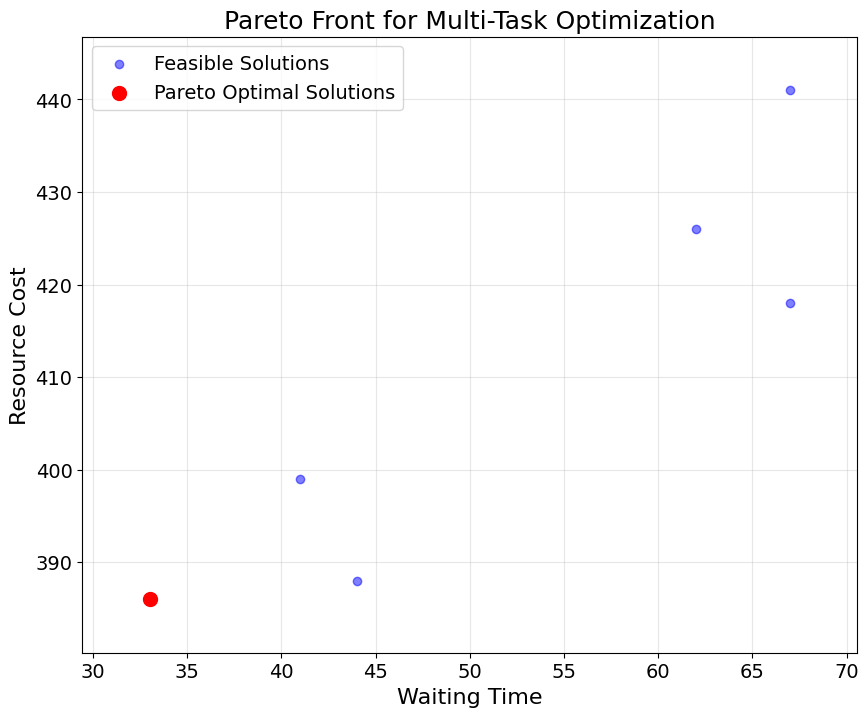


Total feasible solutions: 6
Number of Pareto optimal solutions: 1

Pareto optimal solutions details:
     SubH4_per_D  SubH5_per_E
441        386.0         33.0


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CSVファイルのリスト
file_paths = [
    "./search/job6/exam/optimization_results_job6_6.csv",
    "./search/job6/exam/optimization_results_job6_7.csv",
    "./search/job6/exam/optimization_results_job6_8.csv",
    "./search/job6/exam/optimization_results_job6_9.csv",
    "./search/job6/exam/optimization_results_job6_10.csv",
]

def is_pareto_efficient(costs):
    """
    パレート最適な点を見つける関数
    """
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        dominated_points = np.all(costs >= c, axis=1) & np.any(costs > c, axis=1)
        is_efficient[dominated_points] = False
    return is_efficient

def plot_solutions_with_pareto(file_paths, save_path=None):
    """
    解空間とパレートフロントを可視化する関数
    
    Parameters:
    -----------
    file_paths : list
        CSVファイルのパスのリスト
    save_path : str, optional
        図を保存する場合のファイルパス
    """
    # すべてのデータを統合するリスト
    all_data = []

    # 各ファイルを読み込み
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        all_data.append(df)

    # データフレームを結合
    data = pd.concat(all_data, ignore_index=True)

    # Feasible な解をフィルタリング
    feasible_data = data[data['feasible'] == True]
    
    # 比率の計算
    feasible_data['SubH4_per_D'] = feasible_data['SubH4'] / feasible_data['D']
    feasible_data['SubH5_per_E'] = feasible_data['SubH5'] / feasible_data['E']
    
    # コスト配列の作成
    costs = np.column_stack([
        feasible_data['SubH4_per_D'],
        feasible_data['SubH5_per_E']
    ])
    
    # パレートフロントの計算
    pareto_mask = is_pareto_efficient(costs)
    pareto_points = costs[pareto_mask]
    
    # プロットの作成
    plt.figure(figsize=(10, 8))
    
    # 全ての実行可能解をプロット
    plt.scatter(
        feasible_data['SubH5_per_E'],  # x軸をWaiting Timeに
        feasible_data['SubH4_per_D'],  # y軸をResource Costに
        c='blue',
        alpha=0.5,
        label='Feasible Solutions'
    )
    
    # パレート最適解のプロット
    plt.scatter(
        pareto_points[:, 1],  # x軸をWaiting Timeに
        pareto_points[:, 0],  # y軸をResource Costに
        c='red',
        s=100,
        label='Pareto Optimal Solutions'
    )
    
    # グラフの設定（フォントサイズを大きく）
    plt.ylabel('Resource Cost', fontsize=16)  # y軸ラベルのフォントサイズ
    plt.xlabel('Waiting Time', fontsize=16)   # x軸ラベルのフォントサイズ
    plt.title('Pareto Front for Multi-Task Optimization', fontsize=18)  # タイトルのフォントサイズ
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=14)  # 凡例のフォントサイズ
    plt.xticks(fontsize=14)  # x軸の目盛フォントサイズ
    plt.yticks(fontsize=14)  # y軸の目盛フォントサイズ

    # 軸の範囲を調整
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    plt.xlim(x_min - 0.05 * (x_max - x_min), x_max + 0.05 * (x_max - x_min))
    plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # パレート最適解の数と統計情報を出力
    print(f"\nTotal feasible solutions: {len(feasible_data)}")
    print(f"Number of Pareto optimal solutions: {sum(pareto_mask)}")
    
    return feasible_data.iloc[pareto_mask]

# 使用例
if __name__ == "__main__":
    pareto_solutions = plot_solutions_with_pareto(file_paths)
    
    # パレート最適解の詳細を表示
    print("\nPareto optimal solutions details:")
    print(pareto_solutions[['SubH4_per_D', 'SubH5_per_E']].to_string())


## ペトリネット変換前と後の比較用plot

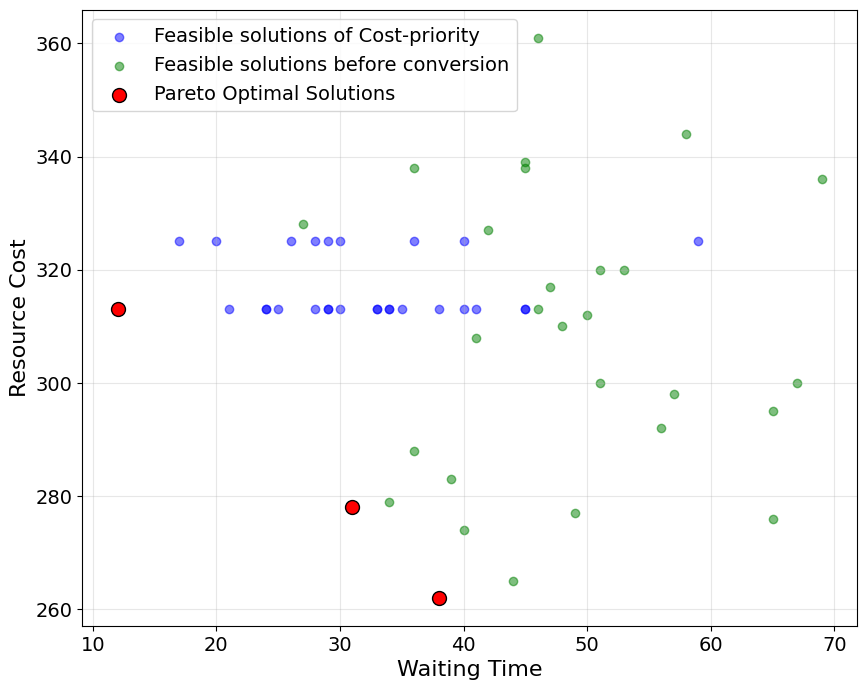


Feasible Solutions (file_paths1): 28
Feasible Solutions (file_paths2): 29
Total Feasible Solutions: 57
Pareto Optimal Solutions: 3

Pareto Optimal Solutions:
    SubH4  SubH5_per_E
4   313.0         12.0
44  278.0         31.0
45  262.0         38.0


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CSVファイルのリスト
file_paths1 = [
    "../FlowShop_ver2/search/job5/exam/optimization_results_job5_task_1.csv",
    "../FlowShop_ver2/search/job5/exam/optimization_results_job5_task_2.csv",
    "../FlowShop_ver2/search/job5/exam/optimization_results_job5_task_3.csv",
    "../FlowShop_ver2/search/job5/exam/optimization_results_job5_task_4.csv",
    "../FlowShop_ver2/search/job5/exam/optimization_results_job5_task_5.csv"]

file_paths2 = [
    "./search/job5/exam/optimization_results_job5_9.csv",
    "./search/job5/exam/optimization_results_job5_10.csv",
    "./search/job5/exam/optimization_results_job5_11.csv",
    "./search/job5/exam/optimization_results_job5_12.csv",
    "./search/job5/exam/optimization_results_job5_13.csv",
]

def is_pareto_efficient(costs):
    """パレート最適な点を見つける関数"""
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        dominated_points = np.all(costs >= c, axis=1) & np.any(costs > c, axis=1)
        is_efficient[dominated_points] = False
    return is_efficient

def load_and_process_data_1(file_paths):
    """file_paths1 のデータを読み込み、処理"""
    all_data = []
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        all_data.append(df)

    data = pd.concat(all_data, ignore_index=True)
    feasible_data = data[data['feasible'] == True].copy()
    
    # 指標を計算
    feasible_data['SubH5_per_E'] = np.where(
        feasible_data['E'] != 0, 
        feasible_data['SubH5'] / feasible_data['E'], 
        np.nan
    )
    feasible_data.dropna(subset=['SubH5_per_E'], inplace=True)
    
    return feasible_data[['SubH4', 'SubH5_per_E']]

def load_and_process_data_2(file_paths):
    """file_paths2 のデータを読み込み、処理"""
    all_data = []
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        all_data.append(df)

    data = pd.concat(all_data, ignore_index=True)
    feasible_data = data[data['feasible'] == True].copy()
    
    # 指標を計算
    feasible_data['SubH4_per_D'] = feasible_data['SubH4'] / feasible_data['D']
    feasible_data['SubH5_per_E'] = feasible_data['SubH5'] / feasible_data['E']
    
    # `SubH4_per_D` を `SubH4` として扱い統一
    return feasible_data[['SubH4_per_D', 'SubH5_per_E']].rename(columns={'SubH4_per_D': 'SubH4'})

def plot_pareto_front(file_paths1, file_paths2, save_path=None):
    """
    2種類の最適化結果のパレートフロントを可視化する
    """
    # データの処理
    data_1 = load_and_process_data_1(file_paths1)
    data_2 = load_and_process_data_2(file_paths2)

    # 統合データの作成
    combined_data = pd.concat([data_1, data_2], ignore_index=True)
    
    # パレートフロントの計算
    costs = combined_data.to_numpy()
    pareto_mask = is_pareto_efficient(costs)
    pareto_points = combined_data.iloc[pareto_mask]

    # プロットの作成
    plt.figure(figsize=(10, 8))

    # file_paths1 の Feasible solutions (青)
    plt.scatter(
        data_1['SubH5_per_E'], 
        data_1['SubH4'], 
        c='blue', alpha=0.5, label='Feasible solutions of Cost-priority'
    )

    # file_paths2 の Feasible solutions (緑)
    plt.scatter(
        data_2['SubH5_per_E'], 
        data_2['SubH4'], 
        c='green', alpha=0.5, label='Feasible solutions before conversion'
    )

    # パレート解 (赤)
    plt.scatter(
        pareto_points['SubH5_per_E'], 
        pareto_points['SubH4'], 
        c='red', s=100, edgecolors='black', label='Pareto Optimal Solutions'
    )

    # 軸ラベル・タイトル（フォントサイズを大きく）
    plt.ylabel('Resource Cost', fontsize=16)
    plt.xlabel('Waiting Time', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # 軸範囲の計算
    x_min, x_max = combined_data['SubH5_per_E'].min(), combined_data['SubH5_per_E'].max()
    y_min, y_max = combined_data['SubH4'].min(), combined_data['SubH4'].max()
    plt.xlim(x_min - 0.05 * (x_max - x_min), x_max + 0.05 * (x_max - x_min))
    plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))

    # 保存オプション
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    # 統計情報の出力
    print(f"\nFeasible Solutions (file_paths1): {len(data_1)}")
    print(f"Feasible Solutions (file_paths2): {len(data_2)}")
    print(f"Total Feasible Solutions: {len(combined_data)}")
    print(f"Pareto Optimal Solutions: {sum(pareto_mask)}")

    return pareto_points

# 使用例
if __name__ == "__main__":
    pareto_solutions = plot_pareto_front(file_paths1, file_paths2)

    print("\nPareto Optimal Solutions:")
    print(pareto_solutions.to_string())

